# Entrenar un modelo de word embedding utilizando el dataset de sarcasmo. 

El dataset  está disponible en aula global). La dimensión de los vectores debe ser **50**. 


Necesitamos actualizar gensim, pero antes debemos instalar una versión específica (1.22.4) de numpy:



In [1]:
!pip install numpy==1.22.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Una vez reiniciado el entorno, actualizamos gensim:

In [ ]:
!pip install gensim --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20443 sha256=924b71dbd3e99f57016d4f7b493851f49c4602e1a066f97e3fe5e76b875fc2b7
  Stored in directory: /root/.cache/pip/wheels/6a/65/c4/d27eeee9ba3fc150a0dae150519591103b9e0dbffde3ae77dc
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3530 sha256=dfe13c95575df4e791ac4c2381c2e7c3793627e3d10ba80688bce8b80e587846
  Stored in directory: /root/.cache/pip/wheels/ba/d9/a0/ddd93af16d5855dd9bad417623e70948fdac119d1d34fb17c8
Successfully built fst-pso miniful
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0

Consultamos las versiones de gensim y numpy:

In [ ]:
import gensim, numpy

print('versión de gensim:', gensim.__version__) # >=4.3.0
print('versión de numpy:', numpy.__version__)   # =1.22.4

versión de gensim: 4.3.0
versión de numpy: 1.22.4


In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

PATH='drive/My Drive/Colab Notebooks/data/'

Mounted at /content/drive


In [3]:
import pandas as pd

train = pd.read_csv(PATH+"/sarcasm/train.csv")
val = pd.read_csv(PATH+"/sarcasm/val.csv")
test = pd.read_csv(PATH+"/sarcasm/test.csv")

# concatenamos los tres datasets
df = pd.concat([train, val, test], axis=0)
# tomamos solo los textos
texts=df['headline']
print('Número total de textos:', len(texts))


Número total de textos: 28503


Recuerda que el primer paso sería transformar los textos a tokens. Definimos la función tokenización que para cada va a procesar cada texto y devolverá una lista de listas de tokens:

In [6]:
import spacy
nlp = spacy.load("en_core_web_sm")

def tokenization(texts):
    """gets a list of sentences and returns a list of lists of tokens"""
    sequences_of_tokens=[]
    for text in texts: 
        doc = nlp(text)
        tokens=[]
        for token in doc:
            if token.is_alpha:
                tokens.append(token.text.lower())
        sequences_of_tokens.append(tokens)
    
    return sequences_of_tokens



Este proceso puede tardar unos minutos:

In [ ]:
sequences=tokenization(texts)

Ahora creamos el modelo usando la clase Word2Vec (tardará unos minutos):

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(sequences, vector_size=50, min_count=5, epochs=100)
word_vectors = model.wv
print(model)
print('tamaño del vocabulario:', len(word_vectors))

Word2Vec<vocab=7374, vector_size=50, alpha=0.025>
tamaño del vocabulario: 7374


Grabamos el modelo:

In [ ]:
word_vectors.save('we_sarcasm.bin')


Ahora utilizamos el modelo para probar los métodos **most_similar** (devuelve la lista de las palabras más similares a una dada), **similarity** (devuelve el grado de similitud entre dos palabras) y **distance** (devuelve la distancia entre dos palabras).

In [ ]:
word_vectors.most_similar('trump')


[('obama', 0.7129382491111755),
 ('congress', 0.5346947908401489),
 ('gop', 0.526868999004364),
 ('netanyahu', 0.5265750288963318),
 ('donald', 0.5218928456306458),
 ('doj', 0.514845073223114),
 ('twitter', 0.5053274631500244),
 ('iran', 0.5013290047645569),
 ('senator', 0.49978625774383545),
 ('ethics', 0.499727338552475)]

In [ ]:
distance = word_vectors.distance("trump", "obama")
similarity = word_vectors.similarity('trump', 'obama')
print(f"{distance:.1f}",f"{similarity:.1f}")

0.3 0.7


In [ ]:
distance = word_vectors.distance("woman", "wife")
similarity = word_vectors.similarity('woman', 'wife')
print(f"{distance:.1f}",f"{similarity:.1f}")

0.4 0.6


In [ ]:
distance = word_vectors.distance("woman", "man")
similarity = word_vectors.similarity('woman', 'man')
print(f"{distance:.1f}",f"{similarity:.1f}")

0.1 0.9


La siguiente función nos permite representar el espacio de los vectores de las palabras:

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_plot(word_vectors):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    words=list(word_vectors.index_to_key)
    for word in words:
        tokens.append(word_vectors[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
   
# tsne_plot(word_vectors)

Muestra el gráfico del espacio vectorial (puede tomar unos minutos):

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


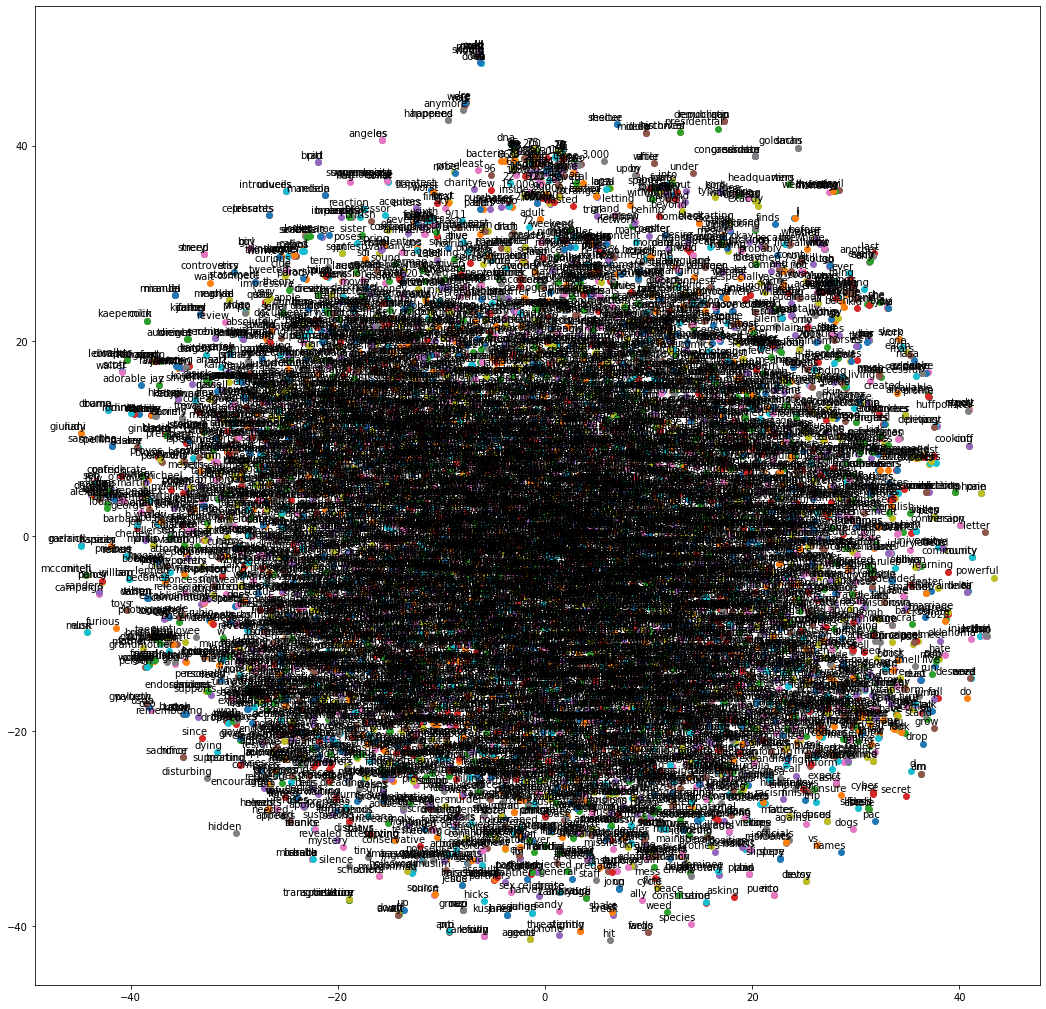

In [ ]:
tsne_plot(word_vectors)